This notebook was done as part of the class "Lesson 1: Practical Deep Learning for Coders 2022". 



In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from fastai.vision.all import *

import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search


In [3]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

The basic steps we'll take are:

Use DuckDuckGo to search for images of "old school tattoos"
Use DuckDuckGo to search for images of "abstract tattoos"
Fine-tune a pretrained neural network to recognise these two groups
Try running this model on a picture of an old school or abstract tattoo and see if it works.

# **Step 1: Download images of old school and abstract tattoos**

In [4]:
urls = search_images('old school tattoo', max_images=1)
urls[0]

Searching for 'old school tattoo'


'https://images.designtrends.com/wp-content/uploads/2016/04/04051056/Old-School-Girl-Head-Tattoo-Design.jpg'

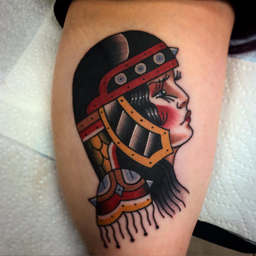

In [5]:
from fastdownload import download_url
dest = 'old school.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'abstract tattoo'


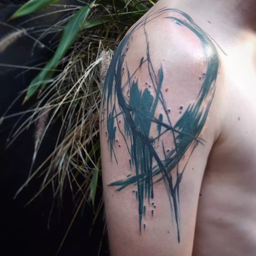

In [6]:
download_url(search_images('abstract tattoo', max_images=1)[0], 'abstract.jpg', show_progress=False)
Image.open('abstract.jpg').to_thumb(256,256)

In [7]:
searches = 'old school','abstract'
path = Path('oldschool_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} tattoo photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} tattooed'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} beautiful tattoo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'old school tattoo photo'
Searching for 'old school tattooed'
Searching for 'old school beautiful tattoo'
Searching for 'abstract tattoo photo'
Searching for 'abstract tattooed'
Searching for 'abstract beautiful tattoo'


In [8]:
print(path)

oldschool_or_not


# **Step 2: Train the model**

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [9]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

Using DataLoaders, which is an object that contains a training set (the images used to create a model) and a validation set (the images used to check the accuracy of a model -- not used during training). In fastai we can create that easily using a DataBlock, and view sample images from it:

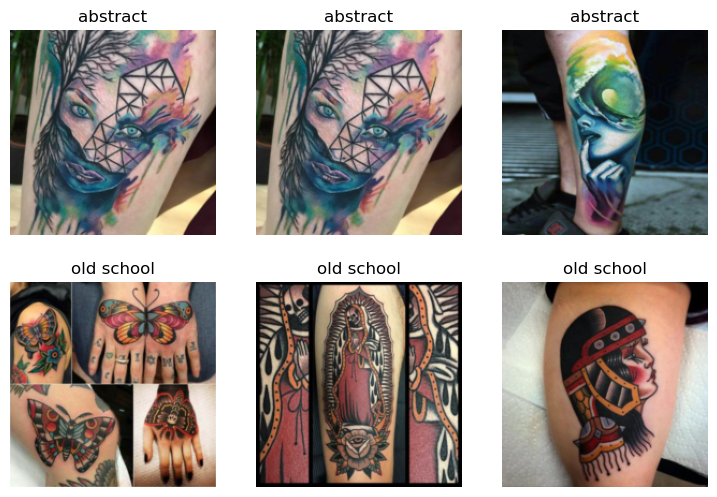

In [10]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

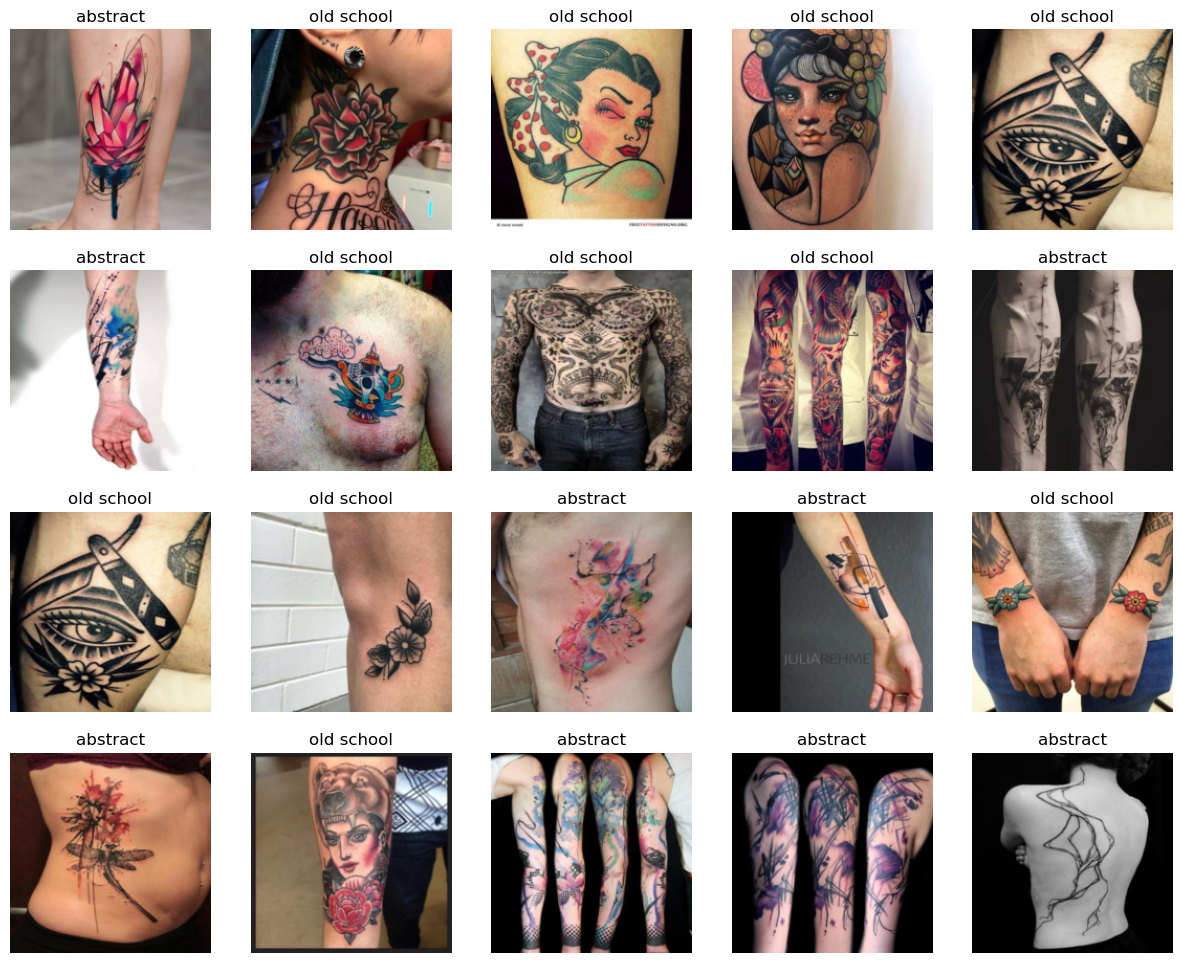

In [11]:
dls.show_batch(max_n=20)

Now we're ready to train our model. The fastest widely used computer vision model is resnet18. 

fastai comes with a helpful fine_tune() method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [12]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.301637,1.251202,0.387097,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.582327,0.487557,0.161290,00:11
1,0.402143,0.277312,0.129032,00:11
2,0.287031,0.186970,0.096774,00:11


Let's see what our model thinks about that tattoo we downloaded at the start:


# **Step 3: Use the model (and builf your own!)**

In [13]:
is_oldschool,_,probs = learn.predict('old school.jpg')
print(f"This is a: {is_oldschool}.")
print(f"Probability it's old school tattoo: {probs[0]:.4f}")

This is a: old school.
Probability it's old school tattoo: 0.0000
